In [22]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns


In [23]:
df = pd.read_csv("fin_health.csv")

In [24]:
X = df.drop(columns=['ID', 'Target'])
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

#### Examine the Distribution of the Target Column

{0: 'High', 1: 'Low', 2: 'Medium'}


<Axes: ylabel='Frequency'>

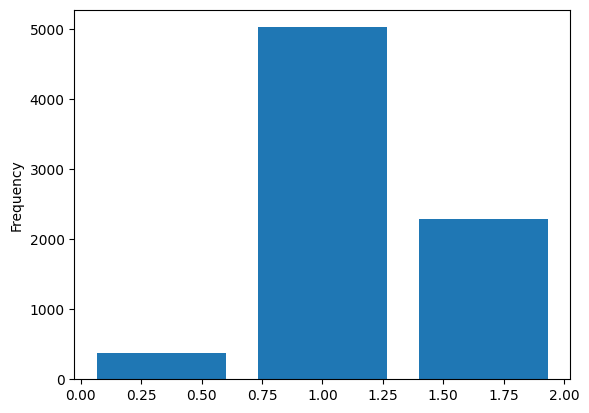

In [25]:
# Map categories to integers automatically
y_train_numeric = y_train.astype('category').cat.codes

# Check mapping
print(dict(enumerate(y_train.astype('category').cat.categories)))

# Plot histogram
y_train_numeric.plot.hist(bins=len(y_train_numeric.unique()), rwidth=0.8)


#### Examine Missing Values

In [26]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [27]:
# Missing values statistics
missing_values = missing_values_table(X_train)
missing_values.head(20)

Your selected dataframe has 37 columns.
There are 35 columns that have missing values.


,Missing Values,% of Total Values
uses_friends_family_savings,3611,46.9
uses_informal_lender,3610,46.9
motivation_make_more_money,3453,44.9
funeral_insurance,3339,43.4
medical_insurance,3339,43.4
business_age_months,3284,42.7
future_risk_theft_stock,3262,42.4
has_debit_card,3223,41.9
has_internet_banking,3223,41.9
has_loan_account,3220,41.9


When it comes time to build our machine learning models, we will have to fill in these missing values (known as imputation). In later work, we will use models such as XGBoost that can handle missing values with no need for imputation. Another option would be to drop columns with a high percentage of missing values, although it is impossible to know ahead of time if these columns will be helpful to our model. Therefore, we will keep all of the columns for now.

#### Column Types

In [28]:
X_train.dtypes.value_counts()

object     31
float64     5
int64       1
Name: count, dtype: int64

Let's now look at the number of unique entries in each of the object (categorical) columns.

In [29]:
# Number of unique classes in each object column
X_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

country                                                             4
attitude_stable_business_environment                                3
attitude_worried_shutdown                                           3
compliance_income_tax                                               4
perception_insurance_doesnt_cover_losses                            3
perception_cannot_afford_insurance                                  3
motor_vehicle_insurance                                             4
has_mobile_money                                                    5
current_problem_cash_flow                                           3
has_cellphone                                                       2
owner_sex                                                           2
offers_credit_to_customers                                          3
attitude_satisfied_with_achievement                                 4
has_credit_card                                                     5
keeps_financial_reco

Most of the categorical variables have a relatively small number of unique entries. We will need to find a way to deal with these categorical variables!

#### Encoding Categorical Variables

for categorical variables with many classes, one-hot encoding is the safest approach because it does not impose arbitrary values to categories. The only downside to one-hot encoding is that the number of features (dimensions of the data) can explode with categorical variables with many categories. To deal with this, we can perform one-hot encoding followed by PCA or other dimensionality reduction methods to reduce the number of dimensions (while still trying to preserve information).


In this notebook, we will use Label Encoding for any categorical variables with only 2 categories and One-Hot Encoding for any categorical variables with more than 2 categories. This process may need to change as we get further into the project, but for now, we will see where this gets us. (We will also not use any dimensionality reduction in this notebook but will explore in future iterations).

#### Label Encoding and One-Hot Encoding

In [30]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in X_train:
    if X_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(X_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(X_train[col])
            # Transform both training and testing data
            X_train[col] = le.transform(X_train[col])
            X_test[col] = le.transform(X_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

0 columns were label encoded.


<mark>note that there is some variables contain only 2 classes but because missing vals "nan" it counts as 3 </mark>

In [31]:
from sklearn.preprocessing import OneHotEncoder

# Select categorical features
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

# Create encoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit on train and transform train
X_train_encoded = encoder.fit_transform(X_train[categorical_features])

# Transform test
X_test_encoded = encoder.transform(X_test[categorical_features])

# Convert to DataFrame with proper column names
encoded_cols = encoder.get_feature_names_out(categorical_features)
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_cols, index=X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_cols, index=X_test.index)

# Combine with numeric features
numeric_features = X_train.select_dtypes(include=['int64','float64']).columns.tolist()
X_train_encoded = pd.concat([X_train[numeric_features], X_train_encoded_df], axis=1)
X_test_encoded = pd.concat([X_test[numeric_features], X_test_encoded_df], axis=1)

print("X_train shape:", X_train_encoded.shape)
print("X_test shape:", X_test_encoded.shape)


X_train shape: (7694, 155)
X_test shape: (1924, 155)


##### Fix Column names

In [32]:
import re
# Clean column names (in case not done yet)
def clean_column_names(df):
    df.columns = [re.sub(r'[^A-Za-z0-9_]+', '_', col) for col in df.columns]
    cols = pd.Series(df.columns)
    for dup in cols[cols.duplicated()].unique():
        cols[cols == dup] = [f"{dup}_{i}" if i != 0 else dup for i in range(sum(cols == dup))]
    df.columns = cols
    return df

X_train_encoded = clean_column_names(X_train_encoded.copy())
X_test_encoded = clean_column_names(X_test_encoded.copy())

In [33]:
X_train_encoded.columns

Index(['owner_age', 'personal_income', 'business_expenses',
       'business_turnover', 'business_age_years', 'business_age_months',
       'country_A', 'country_B', 'country_C', 'country_D',
       ...
       'uses_friends_family_savings_Used_to_have_but_don_t_have_now',
       'uses_friends_family_savings_Used_to_have_but_don_t_have_now_1',
       'uses_friends_family_savings_nan', 'uses_informal_lender_Don_t_know',
       'uses_informal_lender_Don_t_know_Do_not_show_',
       'uses_informal_lender_Have_now', 'uses_informal_lender_Never_had',
       'uses_informal_lender_Used_to_have_but_don_t_have_now',
       'uses_informal_lender_Used_to_have_but_don_t_have_now_1',
       'uses_informal_lender_nan'],
      dtype='object', length=155)

#### Back to Exploratory Data Analysis

##### Anomalies

One problem we always want to be on the lookout for when doing EDA is anomalies within the data. These may be due to mis-typed numbers, errors in measuring equipment, or they could be valid but extreme measurements. One way to support anomalies quantitatively is by looking at the statistics of a column using the describe method.

In [37]:
import re
import pandas as pd
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb



# Fixed parameters (no early stopping in RF mode)
fixed_params = {
    'eval_metric': 'multi_logloss',
    #'verbose': 100
}

num_random_iters = 20
num_cv_folds = 5

# Parameter distributions for LightGBM RF
rf_params = {
    'num_leaves': randint(5, 50),
    'subsample': uniform(0.4, 0.55),        # 0.4 to <1.0
    'subsample_freq': randint(1, 10),
    'colsample_bytree': uniform(0.4, 0.55), # 0.4 to <1.0 (essential for RF)
    'max_depth': randint(3, 20)
}

ens = lgb.LGBMClassifier(
    boosting_type='rf',
    n_estimators=2000,     # Large number since no early stopping
    max_depth=-1,
    random_state=42,
    n_jobs=-1
)

cv = RandomizedSearchCV(
    estimator=ens,
    param_distributions=rf_params,
    n_iter=num_random_iters,
    cv=num_cv_folds,
    scoring='neg_log_loss',
    refit=True,
    random_state=42,
    verbose=True
)

cv.fit(X_train_encoded, y_train, **fixed_params)

print("Best parameters:", cv.best_params_)
print("Best CV score:", cv.best_score_)

# Evaluate best model on test set
best_model = cv.best_estimator_
test_predictions = best_model.predict_proba(X_test_encoded)
# Or predict for classes: best_model.predict(X_test_encoded)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1133
[LightGBM] [Info] Number of data points in the train set: 6155, number of used features: 129
[LightGBM] [Info] Start training from score -3.017910
[LightGBM] [Info] Start training from score -0.426232
[LightGBM] [Info] Start training from score -1.210220
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


KeyboardInterrupt: 